
# Physics-Informed Neural Network for Gravitational Lensing Classification
This notebook implements a Physics-Informed Neural Network (PINN) for classifying gravitational lensing images. The architecture incorporates physical principles of gravitational lensing to improve classification performance.




In [9]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
from tqdm import tqdm # Use standard tqdm for data loading progress

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    Dense, Flatten, Concatenate,
    RandomFlip, RandomRotation # Added for Augmentation
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight # Added for Class Weighting

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Optional: Configure GPU settings if necessary
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# ## 2. Data Loading and Preprocessing

In [10]:
class DataHandler:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.class_dict = {
            0: "no_sub",  # No substructure
            1: "cdm",     # Subhalo substructure (CDM)
            2: "axion"    # Vortex substructure (Axion)
        }
        self.mean = None # For storing training mean
        self.std = None  # For storing training std

    def load_data(self):
        """Load data from disk. Assumes images are already appropriately scaled (e.g., min-max)."""
        print(f"Loading data from {self.data_dir}")
        X = []
        y = []
        
        if not os.path.exists(self.data_dir):
            print(f"Error: Directory {self.data_dir} does not exist")
            return None, None
            
        total_files = 0
        for class_name in self.class_dict.values():
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.exists(class_dir):
                total_files += len([f for f in os.listdir(class_dir) if f.endswith('.npy')])
        
        class_counts = {cls_name: 0 for cls_name in self.class_dict.values()}
        skipped_files = {cls_name: 0 for cls_name in self.class_dict.values()}
        
        with tqdm(total=total_files, desc="Loading data") as pbar:
            for class_idx, class_name in self.class_dict.items():
                class_dir = os.path.join(self.data_dir, class_name)
                
                if not os.path.exists(class_dir):
                    print(f"Warning: Directory {class_dir} does not exist")
                    continue
                    
                files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
                # print(f"Found {len(files)} files in {class_name}") # Optional print
                
                for file in files:
                    try:
                        file_path = os.path.join(class_dir, file)
                        # Allow pickle due to potential object arrays
                        data = np.load(file_path, allow_pickle=True)
                        
                        # Specific handling for potential axion format 
                        # NOTE: This assumes the image is always the first element if it's an object array
                        if data.dtype == 'object':
                           if isinstance(data[0], np.ndarray) and data[0].shape == (64, 64):
                                img = data[0].astype(np.float32) 
                           else:
                                print(f"Warning: Unexpected object array format in {file_path}. Skipping.")
                                skipped_files[class_name] += 1
                                pbar.update(1)
                                continue
                        elif isinstance(data, np.ndarray) and data.shape == (64,64):
                           img = data.astype(np.float32)
                        else:
                           print(f"Warning: Unexpected data type or shape in {file_path}. Skipping.")
                           skipped_files[class_name] += 1
                           pbar.update(1)
                           continue
                        
                        # Basic sanity check on dimensions
                        if img.shape != (64, 64):
                            print(f"Warning: Unexpected dimensions {img.shape} in {file_path}. Skipping.")
                            skipped_files[class_name] += 1
                            pbar.update(1)
                            continue
                        
                        # Normalization is now handled dataset-wide after splitting
                        # img = (img - np.mean(img)) / (np.std(img) + 1e-8)

                        # Check for NaNs or Infs introduced by loading or processing (or in original data)
                        if np.isnan(img).any() or np.isinf(img).any():
                             print(f"Warning: NaN/Inf detected in {file_path}. Skipping.")
                             skipped_files[class_name] += 1
                             pbar.update(1)
                             continue

                        X.append(img)
                        y.append(class_idx)
                        class_counts[class_name] += 1
                        
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}. Skipping.")
                        skipped_files[class_name] += 1
                    pbar.update(1)
        
        print("\nDataset Statistics:")
        for cls_name in self.class_dict.values():
            print(f"  - {cls_name}: {class_counts[cls_name]} images loaded, {skipped_files[cls_name]} files skipped")
        
        if len(X) == 0:
            print("Error: No data was loaded")
            return None, None
            
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.int32)
        
        y_one_hot = tf.keras.utils.to_categorical(y, num_classes=len(self.class_dict), dtype='float32')

        print(f"Loaded {X.shape[0]} samples")
        print(f"X shape: {X.shape}, y shape: {y_one_hot.shape}")
        
        return X, y_one_hot
        
    def split_and_standardize_data(self, test_size=0.2, val_size=0.2, random_state=42):
        """Load, split, and apply dataset-wide Z-score standardization."""
        print("\nLoading and splitting dataset...")
        X, y = self.load_data()
        
        if X is None or y is None:
            print("Error: Failed to load data")
            return None, None, None, None, None, None
        
        # Split into Train/Validation/Test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=np.argmax(y, axis=1)
        )
        
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size_adjusted, 
            random_state=random_state, stratify=np.argmax(y_train_val, axis=1)
        )
        
        # --- Dataset-wide Standardization ---
        print("\nApplying dataset-wide standardization (based on training set)...")
        # Calculate mean and std only on the training data (per-pixel)
        self.mean = np.mean(X_train, axis=0)
        self.std = np.std(X_train, axis=0)
        
        # Add a small epsilon to std to avoid division by zero
        epsilon = 1e-8
        self.std[self.std < epsilon] = epsilon 

        # Apply standardization
        X_train = (X_train - self.mean) / self.std
        X_val = (X_val - self.mean) / self.std
        X_test = (X_test - self.mean) / self.std
        print(f"Calculated training set mean (example pixel): {self.mean[0,0]:.4f}")
        print(f"Calculated training set std (example pixel): {self.std[0,0]:.4f}")

        print(f"\nTraining set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        return X_train, y_train, X_val, y_val, X_test, y_test

#  3. Physics-Informed Neural Network Architecture
 
# The PINN architecture combines:
 1. CNN path for feature extraction
 2. Physics-informed path incorporating gravitational lensing equations
 3. Strong regularization to prevent overfitting
# 
# Physics Components:
 - Coordinate grid system for spatial awareness
 - Radial coordinates for lensing physics
- Angular coordinates for rotational invariance

In [11]:
# Configuration
DATA_DIR = 'multi_class/Dataset' # Make sure this path is correct
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = 64, 64
NUM_CLASSES = 3
EPOCHS = 50 # Kept from original, adjust as needed
LEARNING_RATE = 5e-4 # Kept from original

# --- Load and Prepare Data ---
data_handler = DataHandler(data_dir=DATA_DIR)
X_train, y_train, X_val, y_val, X_test, y_test = data_handler.split_and_standardize_data(random_state=seed)

if X_train is not None:
    # --- Class Weights (Addressing CDM recall) ---
    print("\nCalculating class weights...")
    y_train_indices = np.argmax(y_train, axis=1) # Convert one-hot to indices
    class_weights_array = compute_class_weight(
        'balanced', 
        classes=np.unique(y_train_indices), 
        y=y_train_indices
    )
    class_weight_dict = dict(enumerate(class_weights_array))
    print(f"Class weights: {class_weight_dict}")
    
    # --- Reshape for Conv2D ---
    print("\nReshaping data for CNN input...")
    X_train = X_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
    X_val = X_val.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
    X_test = X_test.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"X_test shape: {X_test.shape}")

    # --- Create TensorFlow Datasets ---
    print("\nCreating TensorFlow datasets...")
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Apply batching and prefetching
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Data preparation complete.")
else:
    print("Data loading failed. Cannot proceed with training.")


Loading and splitting dataset...
Loading data from multi_class/Dataset


Loading data: 100%|█████████████████████████████████████████████████████████████████████████████| 89104/89104 [17:21<00:00, 85.53it/s]



Dataset Statistics:
  - no_sub: 29449 images loaded, 0 files skipped
  - cdm: 29759 images loaded, 0 files skipped
  - axion: 29896 images loaded, 0 files skipped
Loaded 89104 samples
X shape: (89104, 64, 64), y shape: (89104, 3)

Applying dataset-wide standardization (based on training set)...
Calculated training set mean (example pixel): 0.0000
Calculated training set std (example pixel): 0.0000

Training set: 53462 samples
Validation set: 17821 samples
Test set: 17821 samples

Calculating class weights...
Class weights: {0: 1.0085837719546475, 1: 0.9980771025856436, 2: 0.9934589512022893}

Reshaping data for CNN input...
X_train shape: (53462, 64, 64, 1)
X_val shape: (17821, 64, 64, 1)
X_test shape: (17821, 64, 64, 1)

Creating TensorFlow datasets...
Data preparation complete.


In [12]:
def create_pinn_model(input_shape, num_classes, l2_reg=5e-4, dropout_rate=0.3):
    """Creates the PINN-inspired multi-class classification model."""
    print("\nCreating PINN model...")
    print(f"Input shape: {input_shape}")
    print(f"Number of classes: {num_classes}")
    
    inputs = Input(shape=input_shape)

    # --- Data Augmentation ---
    x_aug = RandomFlip("horizontal_and_vertical")(inputs)
    x_aug = RandomRotation(0.2)(x_aug) # Rotate by up to 20%
    
    # --- CNN Feature Extraction Path ---
    # Increased filters slightly, maintained regularization
    x_cnn = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(x_aug)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = MaxPooling2D((2, 2))(x_cnn)
    x_cnn = Dropout(dropout_rate)(x_cnn)
    
    x_cnn = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = MaxPooling2D((2, 2))(x_cnn)
    x_cnn = Dropout(dropout_rate + 0.1)(x_cnn) # Slightly increased dropout deeper
    
    x_cnn = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = MaxPooling2D((2, 2))(x_cnn)
    x_cnn = Dropout(dropout_rate + 0.15)(x_cnn) # Slightly increased dropout deeper
    
    # --- Physics-Informed Path (Coordinates) ---
    coords_x = tf.linspace(-1.0, 1.0, input_shape[0])
    coords_y = tf.linspace(-1.0, 1.0, input_shape[1])
    X, Y = tf.meshgrid(coords_x, coords_y) # Cartesian coordinates
    R = tf.sqrt(X**2 + Y**2)              # Radial coordinate
    Theta = tf.atan2(Y, X)                 # Angle coordinate

    # Stack relevant coordinate features
    physics_features_raw = tf.stack([
        X, 
        Y,
        R,
        tf.cos(Theta), # Use cos/sin to handle angle wrap-around
        tf.sin(Theta)
    ], axis=-1)
    
    # Resize physics features to match CNN output spatial dimensions
    # and tile across batch dimension
    cnn_output_shape = tf.shape(x_cnn)
    physics_features = tf.image.resize(physics_features_raw, (cnn_output_shape[1], cnn_output_shape[2]))
    physics_features = tf.expand_dims(physics_features, axis=0) # Add batch dimension for tiling
    physics_features = tf.tile(physics_features, [cnn_output_shape[0], 1, 1, 1]) # Tile to batch size

    # --- Combine CNN and Physics Features ---
    x_combined = Concatenate()([x_cnn, physics_features])
    
    # --- Final Dense Layers ---
    x = Flatten()(x_combined)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # --- Create and Compile Model ---
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(
        learning_rate=LEARNING_RATE, 
        clipnorm=1.0 # Keep gradient clipping 
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')] 
    )
    
    print("PINN model created successfully.")
    model.summary() # Print model summary
    return model

# 4. Model Training
 
 Training strategy includes:
- Data augmentation for better generalization
 - Early stopping to prevent overfitting
 - Learning rate reduction on plateau
 - Model checkpointing to save best weights


# Create and train the binary model

In [13]:
# Proceed only if data was loaded successfully
if 'X_train' in locals() and X_train is not None:
    print("\n=== Training PINN Model ===")
    
    # Create the model
    model = create_pinn_model(input_shape, NUM_CLASSES)
    
    if model is None:
        raise ValueError("Model creation failed")

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc', 
        patience=7, # Slightly increased patience 
        restore_best_weights=True,
        mode='max', 
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6, 
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        'best_pinn_model.h5', # Updated filename
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    callbacks = [early_stopping, reduce_lr, model_checkpoint]

    # --- Train the Model ---
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weight_dict, # Apply class weights
        verbose=1
    )
    print("\nTraining complete.")
    
    # Optionally load the best weights saved by ModelCheckpoint
    # print("Loading best weights from checkpoint...")
    # model.load_weights('best_pinn_model.h5')
else:
    print("\nSkipping training due to data loading issues.")
    history = None # Ensure history is None if training didn't run


=== Training PINN Model ===

Creating PINN model...
Input shape: (64, 64, 1)
Number of classes: 3
PINN model created successfully.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 random_flip (RandomFlip)       (None, 64, 64, 1)    0           ['input_2[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 64, 64, 1)   0           ['random_flip[0][0]']            
 n)                                                                                               
                                                           

# Evaluate and Plot curves


=== Evaluating Model Performance ===


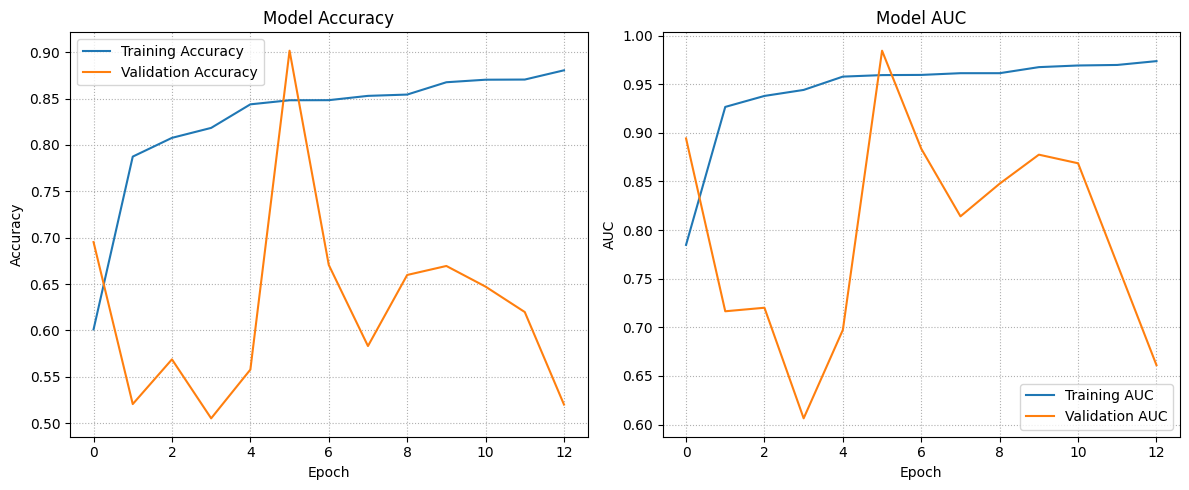


Evaluating on the test dataset...
Loading best weights from best_pinn_model.h5 for final evaluation...
557/557 [==============================] - 46s 80ms/step - loss: 0.4038 - accuracy: 0.9022 - auc: 0.9842

Test Loss: 0.4038
Test Accuracy: 0.9022
Test AUC: 0.9842

Generating predictions on the test dataset...
557/557 [==============================] - 41s 72ms/step

Classification Report:
              precision    recall  f1-score   support

      no_sub       0.91      1.00      0.95      5890
         cdm       0.82      0.92      0.87      5952
       axion       1.00      0.79      0.88      5979

    accuracy                           0.90     17821
   macro avg       0.91      0.90      0.90     17821
weighted avg       0.91      0.90      0.90     17821



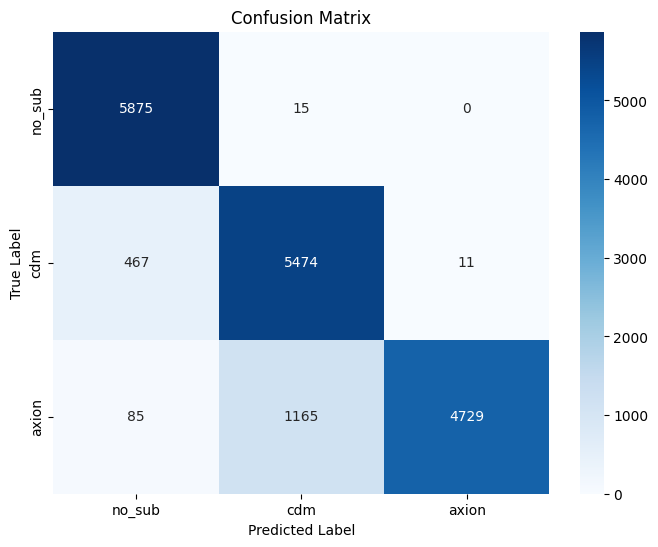

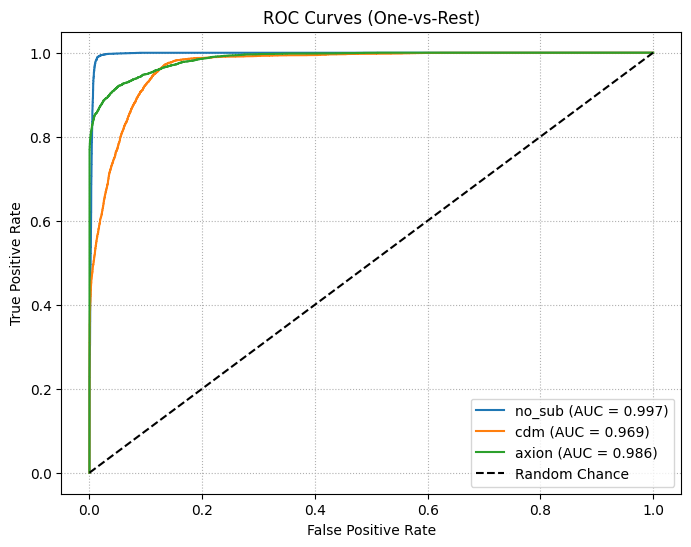

In [14]:
if 'model' in locals() and history is not None: # Check if model was trained
    print("\n=== Evaluating Model Performance ===")
    
    # --- Plot Training History ---
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle=':')

    # AUC Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()

    # --- Evaluate on Test Set ---
    print("\nEvaluating on the test dataset...")
    # Load best weights before final evaluation
    if os.path.exists('best_pinn_model.h5'):
        print("Loading best weights from best_pinn_model.h5 for final evaluation...")
        model.load_weights('best_pinn_model.h5')
    else:
        print("Warning: best_pinn_model.h5 not found. Evaluating with weights at end of training.")
        
    test_loss, test_accuracy, test_auc = model.evaluate(test_dataset, verbose=1)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    # --- Generate Predictions and Analyze Results ---
    print("\nGenerating predictions on the test dataset...")
    y_pred_prob = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    # Extract true labels from the dataset
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_true_classes = np.argmax(y_true, axis=1)

    class_names = list(data_handler.class_dict.values())

    # --- Classification Report ---
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # --- Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- ROC Curves ---
    plt.figure(figsize=(8, 6))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        auc_score = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()
else:
     print("\nModel was not trained or data loading failed. Skipping evaluation.")